In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

df = pd.read_csv('query.csv')

df['date'] = pd.to_datetime(df.time).dt.strftime('%Y/%m/%d')

df['time'] = pd.to_datetime(df.time).dt.strftime('%H:%M:%S')

df = df[['date', 'time', 'latitude', 'longitude', 'depth', 'mag', 'place']]

df

date      time   latitude   longitude    depth   mag  \
0     2024/04/29  17:31:25  17.802600  -66.959500    9.000  3.45   
1     2024/04/29  17:28:54  18.893833  -64.815167   15.130  3.14   
2     2024/04/29  17:15:19  17.806667  -66.955500   11.430  2.77   
3     2024/04/29  16:21:46  24.064600  121.669100   25.217  4.20   
4     2024/04/29  16:14:41  45.290800  148.475000  151.430  4.30   
...          ...       ...        ...         ...      ...   ...   
1667  2024/03/30  01:14:45  51.208700  178.765100   35.000  2.60   
1668  2024/03/30  01:13:14   2.460400  126.776700   44.161  4.70   
1669  2024/03/30  00:49:04 -22.555700  -66.310500  256.042  4.40   
1670  2024/03/30  00:42:24  62.434200 -151.117600   13.200  3.00   
1671  2024/03/30  00:25:05  38.444000   39.340000   10.000  4.80   

                                                  place  
0                     19 km SSW of Guánica, Puerto Rico  
1     62 km NNE of Charlotte Amalie, U.S. Virgin Isl...  
2                     18 km SSW of Guánica, Puerto Rico  
3                      11 km NE of Hualien City, Taiwan  
4                           47 km E of Kuril’sk, Russia  
...                                                 ...  
1667              Rat Islands, Aleutian Islands, Alaska  
1668                    159 km WNW of Tobelo, Indonesia  
1669                 65 km WNW of Abra Pampa, Argentina  
1670                   19 km WSW of Petersville, Alaska  
1671                          2 km E of Sivrice, Turkey  

[1672 rows x 7 columns]

In [2]:
import plotly.express as px

fig = px.scatter_geo(df, lat='latitude',
                     lon='longitude',
                     color="mag",
                     fitbounds='locations'
                     )
fig.update_geos(projection_type="natural earth")

fig.update_layout(title_text = f'Earthquake (magnitude > 2.5) from {min(df.date)} to {max(df.date)}', title_x=0.5)

fig.show()

In [3]:
import geopandas as gpd
df_Taiwan = df[df.place.str.contains('Taiwan')]

gdf = gpd.GeoDataFrame(
    df_Taiwan, geometry=gpd.points_from_xy(df_Taiwan.longitude, df_Taiwan.latitude), crs="EPSG:4326"
)

gdf.explore('mag')

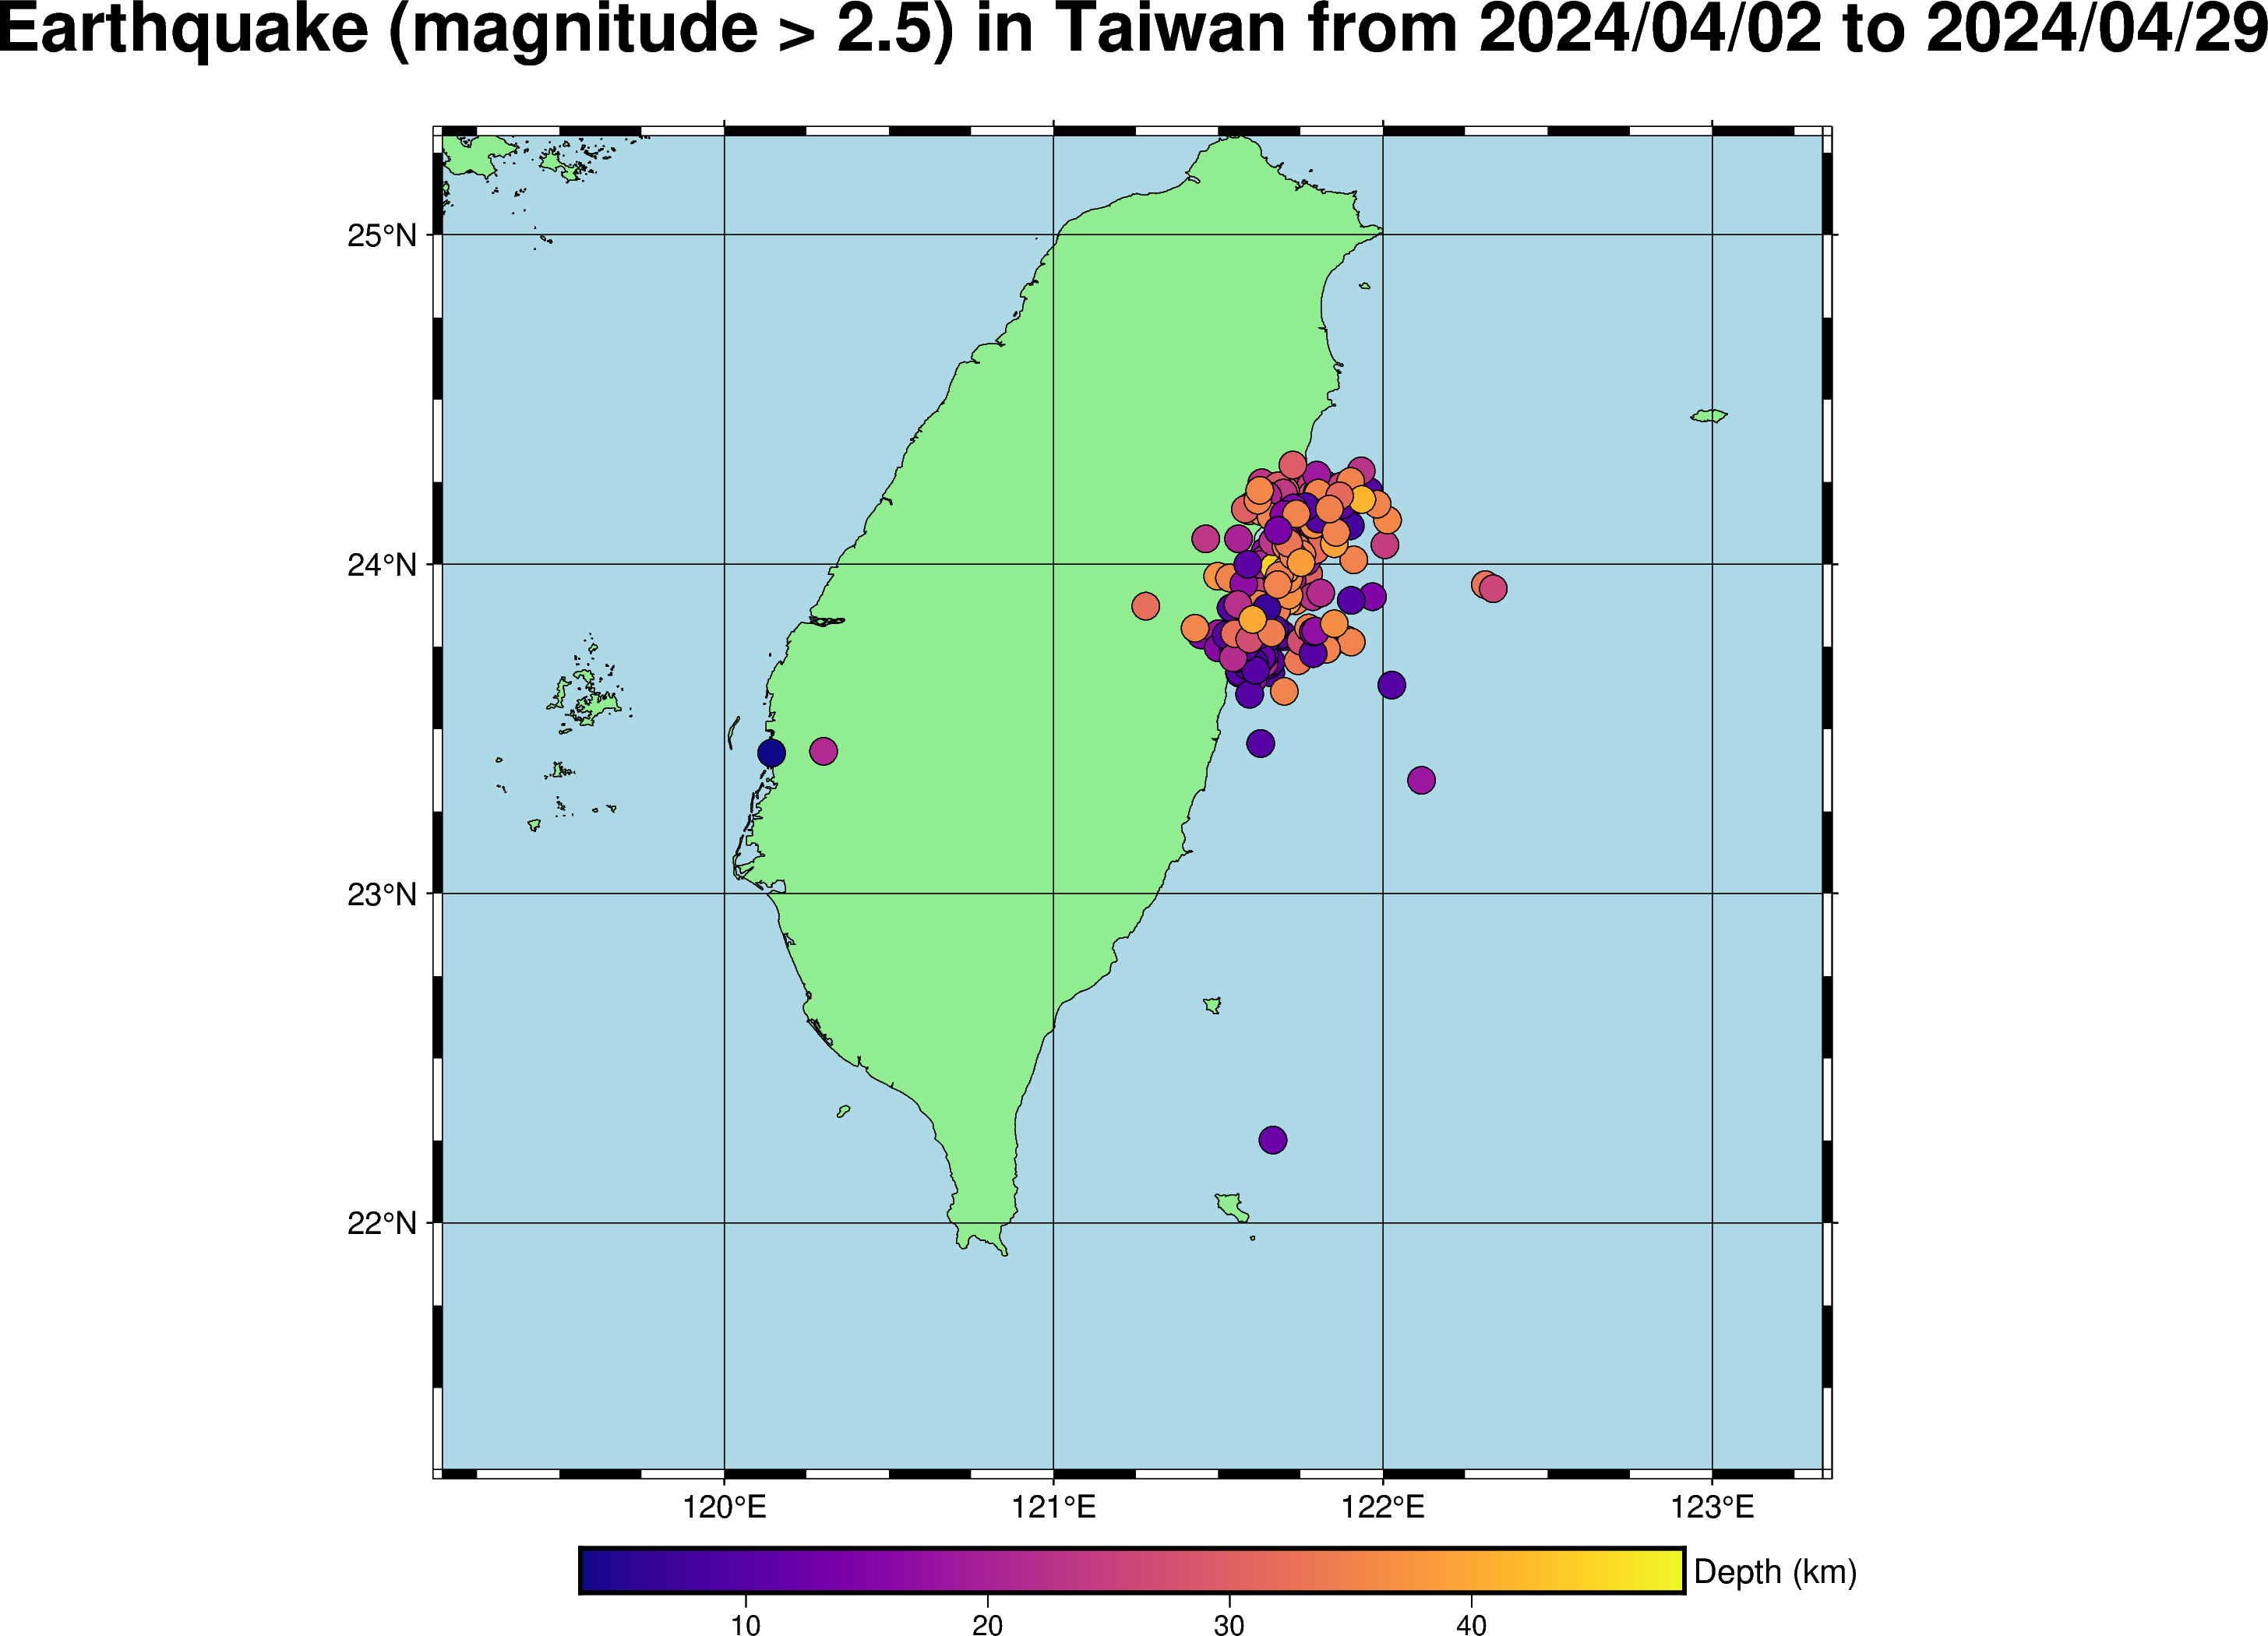

In [4]:
import pygmt

region = [
    df_Taiwan.longitude.min() - 1,
    df_Taiwan.longitude.max() + 1,
    df_Taiwan.latitude.min() - 1,
    df_Taiwan.latitude.max() + 1,
]

fig = pygmt.Figure()

fig.coast(region=region, shorelines=True, land="lightgreen", water="lightblue")

fig.basemap(frame=["afg", f'+tEarthquake (magnitude > 2.5) in Taiwan from {min(df_Taiwan.date)} to {max(df_Taiwan.date)}'])

pygmt.makecpt(cmap="plasma", series=[df_Taiwan.depth.min(), df_Taiwan.depth.max()])

fig.plot(
    x=df_Taiwan.longitude,
    y=df_Taiwan.latitude,
    fill=df_Taiwan.depth,
    cmap = True,
    style="c0.3c",
    pen="black"
)
fig.colorbar(frame=["a", "y+lDepth (km)"])
fig.show()

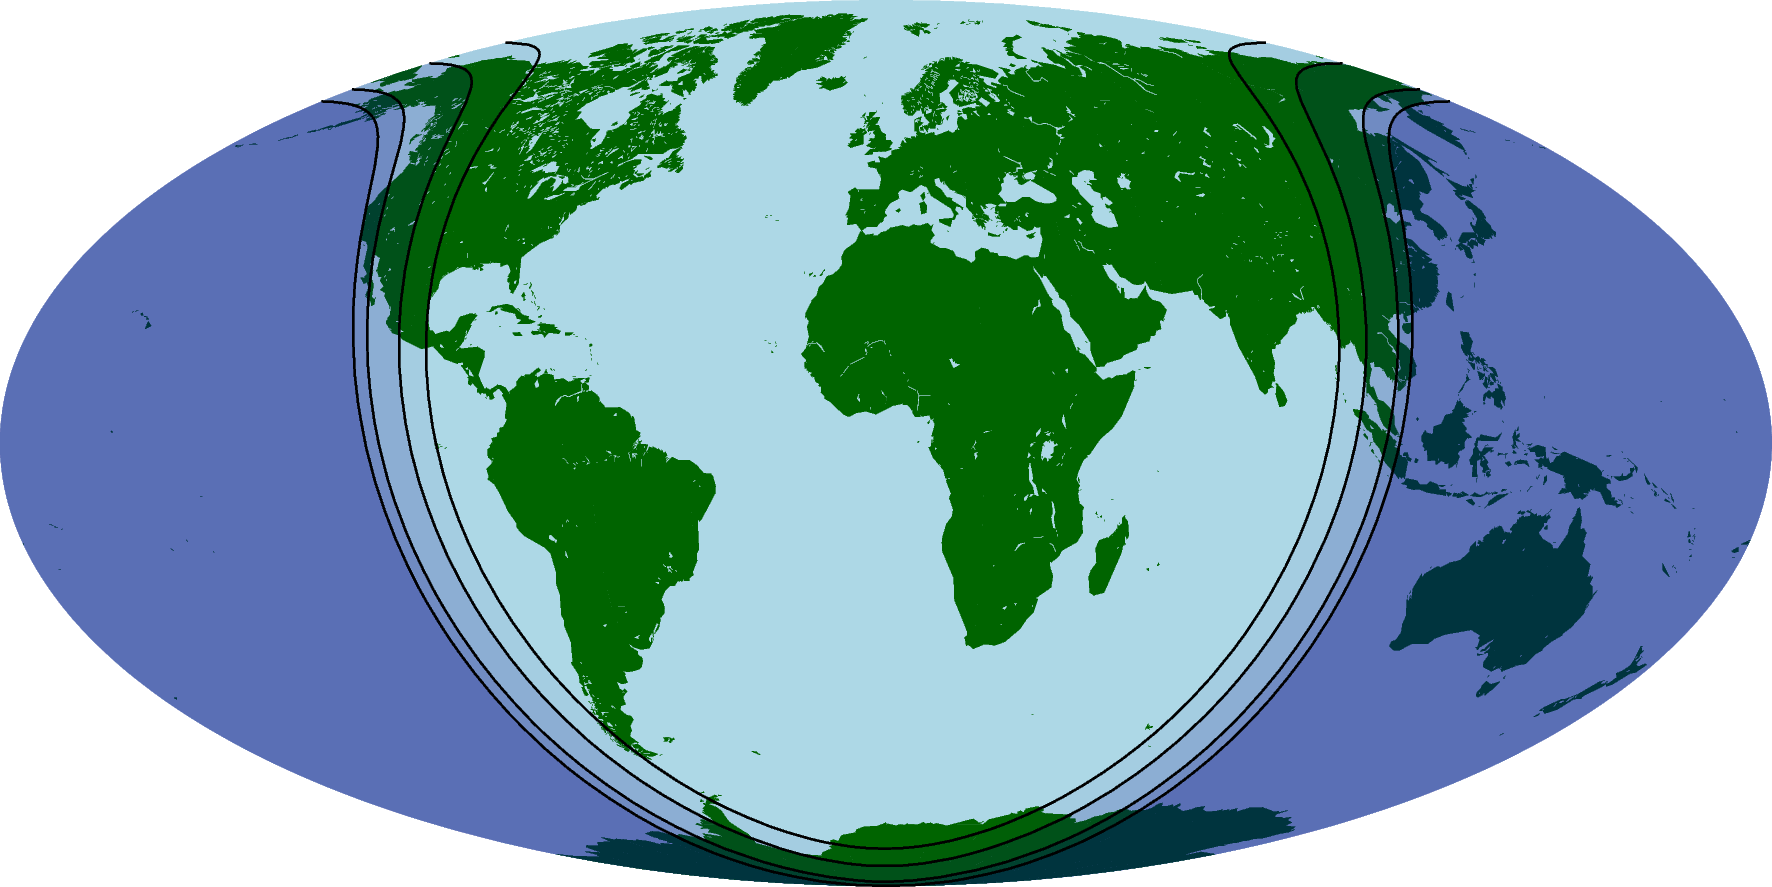

In [5]:
import datetime

fig = pygmt.Figure()
# Create a figure showing the global region on a Mollweide projection
# Land color is set to dark green and water color is set to light blue
fig.coast(region="d", projection="W0/15c", land="darkgreen", water="lightblue")
# Set a time for the day-night terminator and twilights, 17:00 UTC on
# January 1, 2000
terminator_datetime = datetime.datetime(
    year=2024, month=4, day=29, hour=12, minute=0, second=0
)
# Set the pen line to be 0.5 points thick
# Set the fill for the night area to be navy blue at different transparency
# levels
fig.solar(
    terminator="day_night",
    terminator_datetime=terminator_datetime,
    fill="navyblue@95",
    pen="0.5p",
)
fig.solar(
    terminator="civil",
    terminator_datetime=terminator_datetime,
    fill="navyblue@85",
    pen="0.5p",
)
fig.solar(
    terminator="nautical",
    terminator_datetime=terminator_datetime,
    fill="navyblue@80",
    pen="0.5p",
)
fig.solar(
    terminator="astronomical",
    terminator_datetime=terminator_datetime,
    fill="navyblue@80",
    pen="0.5p",
)
fig.show()

In [6]:
# Download LiDAR LAZ file from a URL
lazfile = pygmt.which(
    fname="https://opentopography.s3.sdsc.edu/pc-bulk/NZ19_Wellington/CL2_BQ31_2019_1000_2138.laz",
    download=True,
)
print(lazfile)

CL2_BQ31_2019_1000_2138.laz


In [11]:
import laspy
import rioxarray
import xarray as xr

# Load LAZ data into a pandas DataFrame
lazdata = laspy.read(source=lazfile)
df = pd.DataFrame(
    data={
        "x": lazdata.x.scaled_array(),
        "y": lazdata.y.scaled_array(),
        "z": lazdata.z.scaled_array(),
        "classification": lazdata.classification,
    }
)
region = pygmt.info(data=df[["x", "y"]], spacing=1)  # West, East, South, North
df

x           y      z  classification
0        1749771.56  5427498.77 -0.724               2
1        1749771.52  5427498.46 -0.708               2
2        1749771.48  5427498.15 -0.700               2
3        1749771.45  5427497.84 -0.683               2
4        1749771.41  5427497.54 -0.630               2
...             ...         ...    ...             ...
7322697  1749760.07  5427559.50 -0.446              18
7322698  1749760.23  5427567.65 -0.488               9
7322699  1749760.26  5427567.98 -0.442               9
7322700  1749760.29  5427568.29 -0.417               9
7322701  1749760.32  5427568.62 -0.404               9

[7322702 rows x 4 columns]

In [12]:
df = df.query(expr="classification != 18")
df

x           y      z  classification
0        1749771.56  5427498.77 -0.724               2
1        1749771.52  5427498.46 -0.708               2
2        1749771.48  5427498.15 -0.700               2
3        1749771.45  5427497.84 -0.683               2
4        1749771.41  5427497.54 -0.630               2
...             ...         ...    ...             ...
7322687  1749760.95  5427567.17 -0.479               9
7322698  1749760.23  5427567.65 -0.488               9
7322699  1749760.26  5427567.98 -0.442               9
7322700  1749760.29  5427568.29 -0.417               9
7322701  1749760.32  5427568.62 -0.404               9

[7232453 rows x 4 columns]

In [13]:
# Preprocess LiDAR data using blockmedian
df_trimmed = pygmt.blockmedian(
    data=df[["x", "y", "z"]],
    T=0.99,  # 99th quantile, i.e. the highest point
    spacing="1+e",
    region=region,
)
df_trimmed

x           y        z
0       1749760.05  5427599.54   -0.755
1       1749760.67  5427599.83   -0.737
2       1749761.87  5427599.71   -0.747
3       1749765.39  5427599.55   -0.701
4       1749765.96  5427599.73   -0.742
...            ...         ...      ...
311584  1750236.41  5426880.41  178.756
311585  1750237.32  5426880.47  179.132
311586  1750238.50  5426880.40  179.232
311587  1750239.36  5426880.46  179.517
311588  1750239.99  5426880.49  179.622

[311589 rows x 3 columns]

In [15]:
# Create a Digital Surface Elevation Model with
# a spatial resolution of 1m.
grid = pygmt.surface(
    x=df_trimmed.x,
    y=df_trimmed.y,
    z=df_trimmed.z,
    spacing="1+e",
    region=region,  # xmin, xmax, ymin, ymax
    T=0.35,  # tension factor
)

C:\Users\slin\AppData\Local\Temp\ipykernel_15460\2740553720.py:3: SyntaxWarning:

Short-form parameter (T) is not recommended. Use long-form parameter 'tension' instead.

surface [WARNING]: 53243 unusable points were supplied; these will be ignored.
surface [WARNING]: You should have pre-processed the data with block-mean, -median, or -mode.
surface [WARNING]: Check that previous processing steps write results with enough decimals.
surface [WARNING]: Possibly some data were half-way between nodes and subject to IEEE 754 rounding.


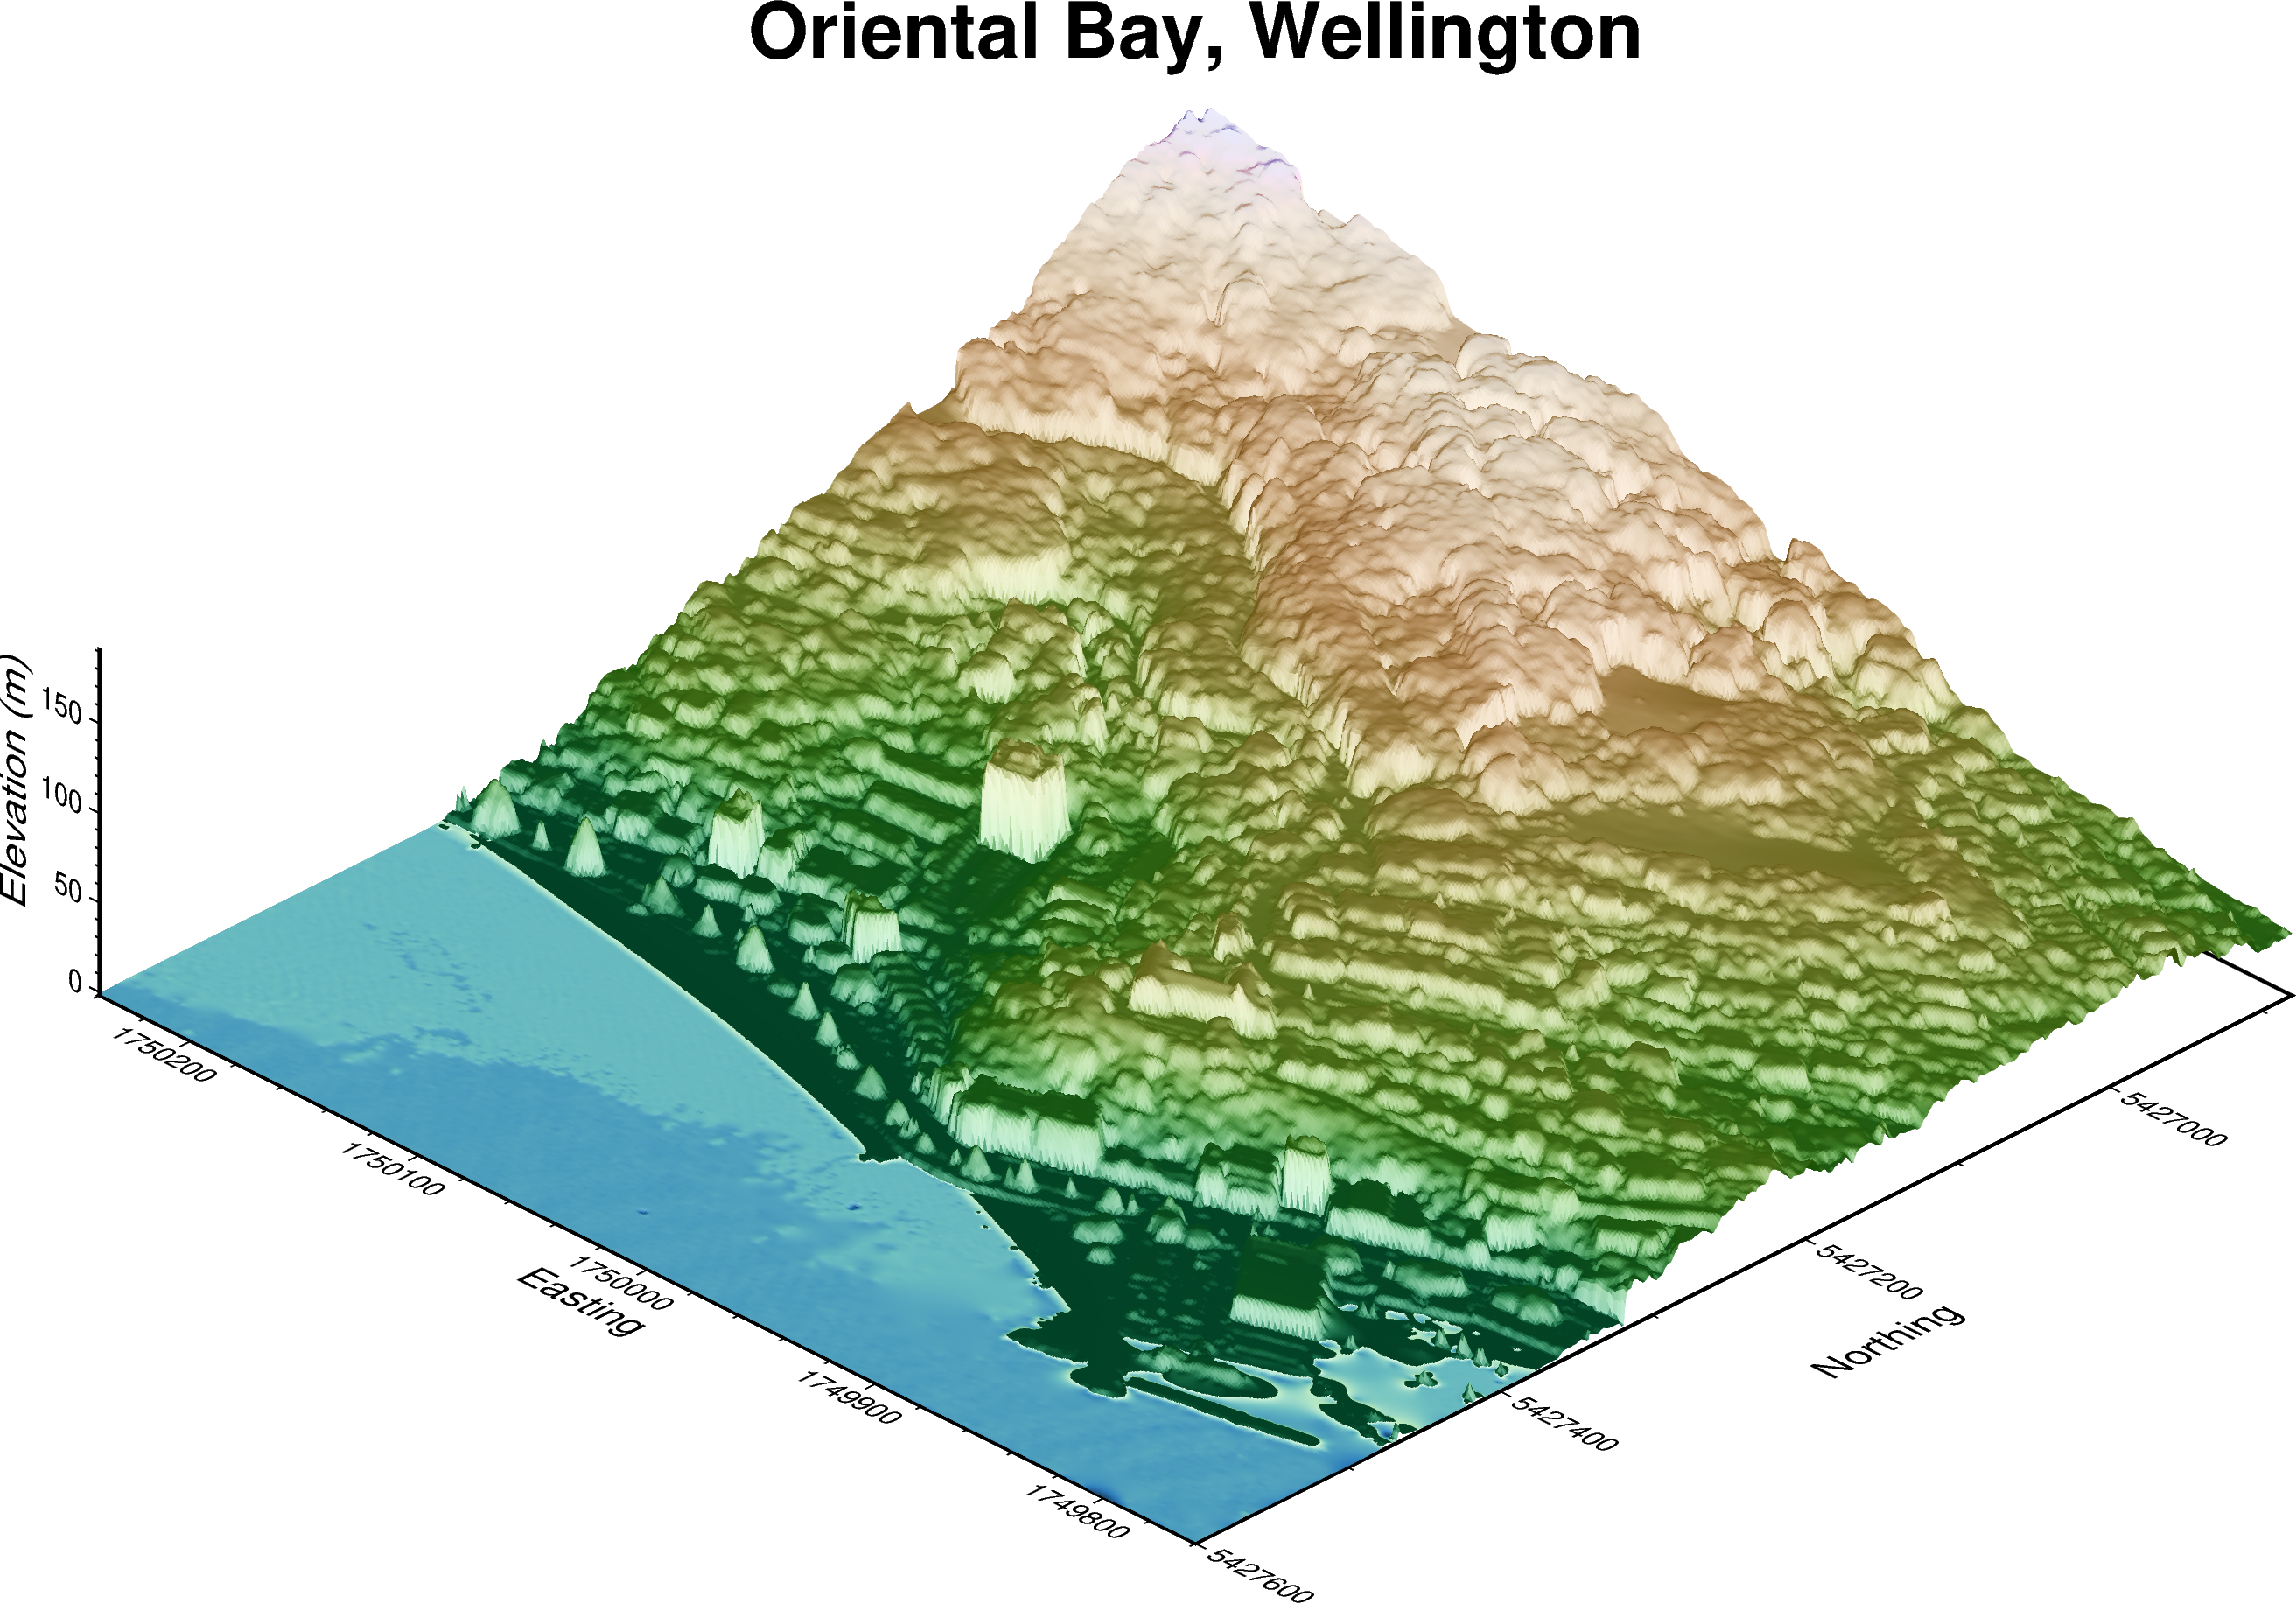

In [17]:
fig3 = pygmt.Figure()
fig3.grdview(
    grid=grid,
    cmap="bukavu",
    surftype="s",  # surface plot
    perspective=[315, 30],  # azimuth bearing, and elevation angle
    zscale=0.02,  # vertical exaggeration
    shading=True,  # hillshading
    frame=[
        "xaf+lEasting",
        "yaf+lNorthing",
        "zaf+lElevation (m)",
        "+tOriental Bay, Wellington",
    ],
)
fig3.show()